<a href="https://colab.research.google.com/github/scomri/CV-MiniProjects/blob/main/CNN_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification - CNN

## Introduction

Welcome to this Python notebook, where I present and discuss a mini-project focused on developing, training, and testing a Convolutional Neural Network model to identify the presence of sunglasses in face images.

**The dataset used for this project** is sourced from the UCI Machine Learning Repository's CMU Face Images dataset, available at https://archive.ics.uci.edu/ml/datasets/CMU+Face+Images.
<br> The dataset consists of samples organized into two folders, corresponding to the two classes.

**The main objective of this project** is to develop a Convolutional Neural Network (CNN) model, leveraging various concepts such as train/validation/test split, grid-search for hyperparameter tuning, cross-validation, and more.

The notebook you are currently exploring is divided into several sections, each serving a specific purpose.


*   *Loading the Data:* In this section, I focus on loading the data and performing necessary cleaning and transformations if required. It is essential to ensure the data is in a suitable format for subsequent model training and evaluation.

*   *Training the Models:* This section is dedicated to training the models while searching for optimal hyperparameters. By systematically exploring different hyperparameter combinations, we aim to identify the most effective settings for achieving high model performance.

* *Performance Evaluation on the Test Set:* After training the models, it is crucial to evaluate their performance on an unseen test set. In this section, I report the evaluation metrics used to assess the model's effectiveness in identifying sunglasses in face images. Thoughtful consideration has been given to selecting appropriate evaluation metrics for this specific task.

Additionally, I will address the following questions, providing insights into various aspects of the model and its training process:

* *Does the model overfit?*
* *What is the effect of batch size? Do we observe this effect in the current task?*
* *What was the optimal optimizer? Why?*

By thoroughly examining these questions, we can gain a deeper understanding of the model's behavior and performance characteristics.

## Install & Import Packages

In [ ]:
!pip install scikeras

In [58]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, learning_curve, ShuffleSplit, GridSearchCV, KFold, RepeatedKFold
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, RocCurveDisplay, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay
import seaborn as sns


## Extract Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir_root = '/content/drive/MyDrive/PersonalProjects/Computer Vision Mini-Projects'

In [5]:
import os
from google.colab import files
import zipfile

# Create the main directory

try:
    os.mkdir(f'{dir_root}/CMUFaceImages_Data')
except OSError:
    print ("Creation of the directory 'CMUFaceImages_Data' failed")
else:
    print ("Successfully created the directory 'CMUFaceImages_Data'")


# Extract the zip file
zip_file_path = os.path.join(dir_root, 'CMUFaceImages.zip')

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(dir_root, 'CMUFaceImages_Data'))
except zipfile.BadZipFile:
    print("Failed to extract the zip file")
else:
    print("Successfully extracted the zip file")



Creation of the directory 'CMUFaceImages_Data' failed
Successfully extracted the zip file


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, learning_curve, ShuffleSplit, GridSearchCV, KFold, RepeatedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, RocCurveDisplay, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
from scikeras.wrappers import KerasClassifier
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

## Load Data

In [6]:
# Image dimensions
IMG_WIDTH = 32
IMG_HEIGHT = 30

# Root folder path containing the image dataset
IMG_FOLDER = f'{dir_root}/CMUFaceImages_Data/'

def create_dataset(img_folder):
    """
    Function to create the dataset by loading and preprocessing the images.

    Args:
        img_folder (str): Path to the root folder containing the image dataset.

    Returns:
        img_data_array (list): List of preprocessed image data arrays.
        class_name (list): List of corresponding class names.

    """
    img_data_array = []
    class_name = []

    for dir_class in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir_class)):
            image_path = os.path.join(img_folder, dir_class, file)
            # The image is loaded using cv2.imread with the cv2.COLOR_BGR2RGB flag
            # This function reads the image from the given path and converts it to the RGB color space
            image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            # Normalize image data by dividing each pixel value by 255, this scales the pixel values between 0 and 1
            image /= 255
            img_data_array.append(image)
            class_name.append(dir_class)

    return img_data_array, class_name

# Extract the image array and class name
img_data, class_name = create_dataset(IMG_FOLDER)

# Create a dictionary mapping class names to numeric values
target_dict = {k: v for v, k in enumerate(np.unique(class_name))}

# Convert the class_names to their respective numeric value based on the dictionary
target_val = [target_dict[class_name[i]] for i in range(len(class_name))]

## Transform Data

In [7]:
# Convert to X - a 3D array (samples, width, height) and y - 0/1
X = tf.cast(np.array(img_data), tf.float64)
y = tf.cast(list(map(int, target_val)), tf.int32)

In [8]:
# Convert EagenTensors to numpy arrays
# certain operations or external libraries may require working with numpy arrays instead of TensorFlow tensors

x = X.numpy()
y = y.numpy()

## Train / Validation / Test Split

In [11]:
# Split data into train, validation and test

# Test and train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Valiadtion
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=0)

## Build and Train the Model

In [12]:
# Set color channels value to 1 because we have black and white images, not colored
input_shape = (x_train.shape[1], x_train.shape[2], 1)
print(input_shape)

(32, 30, 1)


In [14]:
def create_cnn_model(model_input_shape=(32, 30, 1), model_kernel_size=(3, 3), model_optimizer='adam'):
    """
    Function to create a convolutional neural network (CNN) model for image classification.

    Args:
        model_input_shape (tuple): Input shape of the image data in the format (height, width, channels).
        model_kernel_size (tuple): Kernel size for the convolutional layers in the format (height, width).
        model_optimizer (str or optimizer): Optimizer to be used for model compilation.

    Returns:
        model (tf.keras.Model): Compiled CNN model for image classification.

    """
    # Sequential model
    # The Sequential model is a linear stack of layers, where each layer feeds its output into the next layer
    model = keras.models.Sequential()

    # Create convolutional base
    # The model uses three Conv2D layers with different parameters
    model.add(layers.Conv2D(filters=32, kernel_size=model_kernel_size, activation='relu', input_shape=model_input_shape))
    # After each Conv2D layer, a MaxPooling2D layer with a pool size of (2, 2) is added
    # Max pooling reduces the spatial dimensions of the output feature maps
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=64, kernel_size=model_kernel_size, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=64, kernel_size=model_kernel_size, activation='relu'))

    # Following the convolutional base, add a Flatten layer to convert the 2D feature maps into a 1D vector
    # This prepares the data for the subsequent dense layers
    model.add(layers.Flatten())

    # Two dense layers are added on top of the flattened output
    model.add(layers.Dense(units=64, activation='relu'))
    # The last dense layer a 'sigmoid' activation function, which is suitable for binary classification problems
    model.add(layers.Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=model_optimizer,
                  loss='binary_crossentropy', # This loss function is commonly used for binary classification problems
                  metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

    return model


### Create Base Model with Default Parameters

In [15]:
base_model = create_cnn_model()

In [16]:
# Display architecture
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [17]:
# Train the model

base_history = base_model.fit(x_train, y_train, epochs=10, batch_size= 32, validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
14/14 [==============================] - 2s 43ms/step - loss: 0.6884 - accuracy: 0.5482 - precision: 0.5467 - recall: 0.5642 - val_loss: 0.6662 - val_accuracy: 0.6508 - val_precision: 0.6000 - val_recall: 0.9375
Epoch 2/10
14/14 [==============================] - 0s 36ms/step - loss: 0.6310 - accuracy: 0.6514 - precision: 0.6138 - recall: 0.8165 - val_loss: 0.5676 - val_accuracy: 0.6984 - val_precision: 0.6857 - val_recall: 0.7500
Epoch 3/10
14/14 [==============================] - 1s 36ms/step - loss: 0.4807 - accuracy: 0.7844 - precision: 0.8039 - recall: 0.7523 - val_loss: 0.5229 - val_accuracy: 0.7460 - val_precision: 0.8333 - val_recall: 0.6250
Epoch 4/10
14/14 [==============================] - 0s 28ms/step - loss: 0.3837 - accuracy: 0.8257 - precision: 0.8480 - recall: 0.7936 - val_loss: 0.5232 - val_accuracy: 0.7619 - val_precision: 0.7297 - val_recall: 0.8438
Epoch 5/10
14/14 [==============================] - 0s 27ms/step - loss: 0.3327 - accuracy: 0.8486 - precisi

### Base Model Evaluation

In [18]:
def eval_metrics(my_model, x_set, y_set):
    """
    Function to evaluate and print the performance metrics of a given model on a dataset.

    Args:
        my_model (tf.keras.Model): Model to be evaluated.
        x_set (numpy.ndarray): Input data for evaluation.
        y_set (numpy.ndarray): Target data for evaluation.

    Returns:
        loss (float): Loss value of the evaluated model.
        accuracy (float): Accuracy value of the evaluated model.
        precision (float): Precision value of the evaluated model.
        recall (float): Recall value of the evaluated model.

    """
    # Evaluate the model
    loss, accuracy, precision, recall = my_model.evaluate(x_set, y_set, verbose=0)

    # Print model evaluation metrics results
    print(f"Model Loss: {loss}")
    print(f"Model Accuracy: {accuracy}")
    print(f"Model Precision: {precision}")
    print(f"Model Recall: {recall}")

    return loss, accuracy, precision, recall


In [19]:
train_loss, train_acc, train_prec, train_recall  = eval_metrics(base_model, x_train, y_train)

Model Loss: 0.13936790823936462
Model Accuracy: 0.9587156176567078
Model Precision: 0.9807692170143127
Model Recall: 0.9357798099517822


In [21]:
def plot_history_metric(history, metric):
    """
    Function to plot a specific metric over epochs from the training history.

    Args:
        history (tf.keras.callbacks.History): Training history object returned by the model.fit() method.
        metric (str): Name of the metric to be plotted.

    Returns:
        None

    """
    # Plot metric vs. epochs graph
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
    plt.title(f"Model {metric}")
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['Train', "Validation"], loc='lower right')
    plt.show()


In [22]:
base_history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

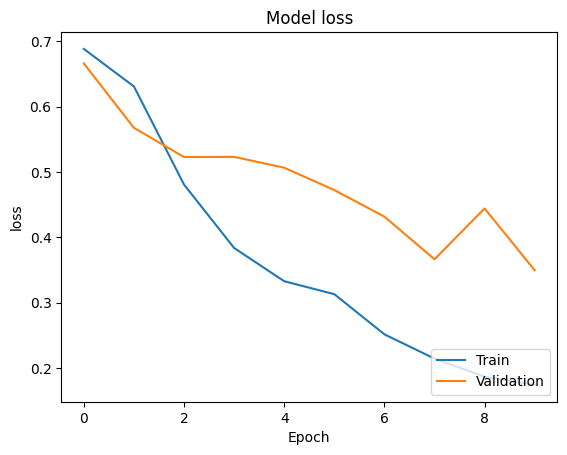

In [25]:
plot_history_metric(base_history, 'loss')

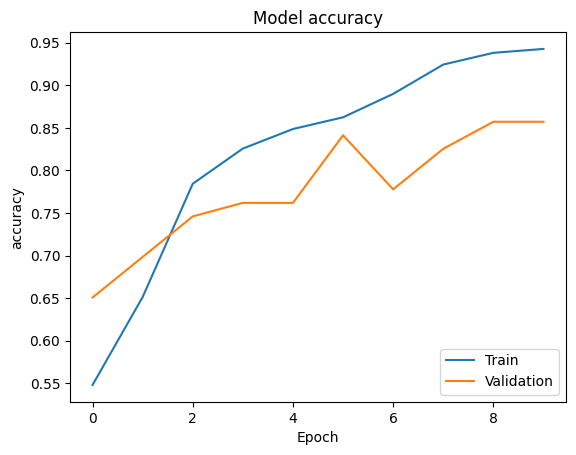

In [26]:
plot_history_metric(base_history, 'accuracy')

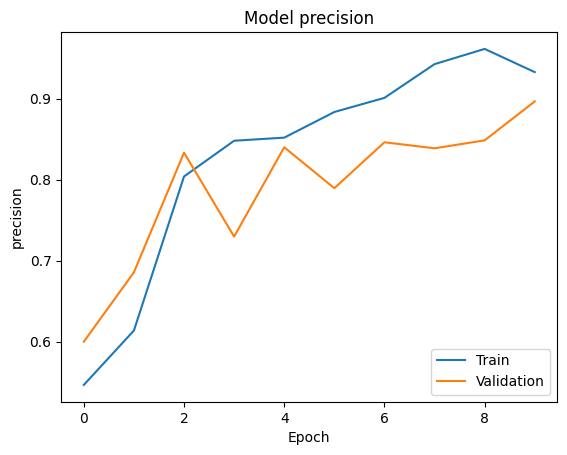

In [27]:
plot_history_metric(base_history, 'precision')

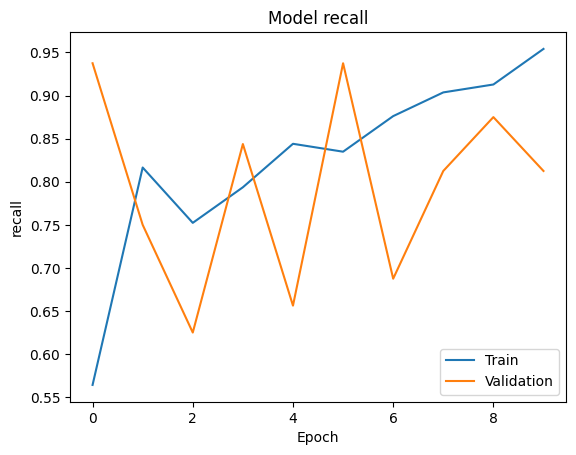

In [28]:
plot_history_metric(base_history, 'recall')

## Grid Search

Now in order to find the optimal hyperparameters for our model, we will use grid search.

In [32]:
# Wrap model with scikit-learn in order to run grid search
keras_clf = KerasClassifier(build_fn=create_cnn_model, verbose=1)

param_grid = dict(epochs=[10, 20, 30],
                  batch_size=[32, 64],
                  optimizer=['adam', 'sgd', 'adagrad'])

print(f"Hyper parameters to check in Grid Search: {param_grid}")

Hyper parameters to check in Grid Search: {'epochs': [10, 20, 30], 'batch_size': [32, 64], 'optimizer': ['adam', 'sgd', 'adagrad']}


In [33]:
grid_search_cv = GridSearchCV(estimator=keras_clf, param_grid=param_grid, n_jobs=-1, cv=3)

grid_search_res = grid_search_cv.fit(x_train, y_train)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


14/14 [==============================] - 2s 29ms/step - loss: 0.6968 - accuracy: 0.5665 - precision_1: 0.5443 - recall_1: 0.8165
Epoch 2/30
14/14 [==============================] - 0s 25ms/step - loss: 0.6808 - accuracy: 0.5734 - precision_1: 0.6111 - recall_1: 0.4037
Epoch 3/30
14/14 [==============================] - 0s 25ms/step - loss: 0.5939 - accuracy: 0.7706 - precision_1: 0.7458 - recall_1: 0.8211
Epoch 4/30
14/14 [==============================] - 0s 33ms/step - loss: 0.4700 - accuracy: 0.7683 - precision_1: 0.8197 - recall_1: 0.6881
Epoch 5/30
14/14 [==============================] - 1s 43ms/step - loss: 0.3961 - accuracy: 0.8028 - precision_1: 0.8267 - recall_1: 0.7661
Epoch 6/30
14/14 [==============================] - 1s 42ms/step - loss: 0.3127 - accuracy: 0.8784 - precision_1: 0.8910 - recall_1: 0.8624
Epoch 7/30
14/14 [==============================] - 1s 58ms/step - loss: 0.2608 - accuracy: 0.9014 - precision_1: 0.9147 - recall_1: 0.8853
Epoch 8/30
14/14 [=============

### Grid Search Results

In [38]:
# Print grid search results
print("The best hyper params for the CNN model:", grid_search_res.best_params_ )
print(f"Best accuracy score: {grid_search_res.best_score_}")

The best hyper params for the CNN model: {'batch_size': 32, 'epochs': 30, 'optimizer': 'adam'}
Best accuracy score: 0.9289245788064872


## Train Model with Best Hyper Parameters

In [39]:
# Save best params from grid search results
best_batch_size = grid_search_res.best_params_['batch_size']

best_epochs = grid_search_res.best_params_['epochs']

best_optimizer = grid_search_res.best_params_['optimizer']

In [40]:
# Train the model with the best params from grid search
best_model = create_cnn_model(model_optimizer=best_optimizer)
best_history = best_model.fit(x_train, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(x_val, y_val), verbose=1)

Epoch 1/30
14/14 [==============================] - 1s 41ms/step - loss: 0.6969 - accuracy: 0.4839 - precision_2: 0.4855 - recall_2: 0.5367 - val_loss: 0.6858 - val_accuracy: 0.5079 - val_precision_2: 0.5085 - val_recall_2: 0.9375
Epoch 2/30
14/14 [==============================] - 0s 27ms/step - loss: 0.6724 - accuracy: 0.6216 - precision_2: 0.5886 - recall_2: 0.8073 - val_loss: 0.6450 - val_accuracy: 0.7302 - val_precision_2: 0.8947 - val_recall_2: 0.5312
Epoch 3/30
14/14 [==============================] - 0s 29ms/step - loss: 0.5682 - accuracy: 0.7638 - precision_2: 0.8075 - recall_2: 0.6927 - val_loss: 0.5543 - val_accuracy: 0.7143 - val_precision_2: 0.8182 - val_recall_2: 0.5625
Epoch 4/30
14/14 [==============================] - 0s 28ms/step - loss: 0.4750 - accuracy: 0.7523 - precision_2: 0.7895 - recall_2: 0.6881 - val_loss: 0.5226 - val_accuracy: 0.7302 - val_precision_2: 0.6829 - val_recall_2: 0.8750
Epoch 5/30
14/14 [==============================] - 0s 28ms/step - loss: 0.4

In [41]:
# Predict the probabilities of class labels for the test data using the best trained model

pred_proba_best = best_model.predict(x_test)

4/4 [==============================] - 0s 8ms/step


In [42]:
# Create labels list by predicted probabilities

pred_proba_thresh = 0.5

y_pred = []
for pred in pred_proba_best:
  if pred > pred_proba_thresh:
    y_pred.append(1)
  else:
    y_pred.append(0)

## Performance Report

### Model Evaluation After Grid Search

In [43]:
# Model evaluation metrics results

best_train_loss, best_train_acc, best_train_prec, best_train_recall = eval_metrics(best_model, x_train, y_train)

Model Loss: 0.0064665996469557285
Model Accuracy: 1.0
Model Precision: 1.0
Model Recall: 1.0


In [44]:
best_history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_2', 'recall_2', 'val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2'])

#### Loss

The 'loss' metric measures how well the model is able to predict the correct label for an image.
<br> Low loss value indicates that the model is making more accurate predictions.

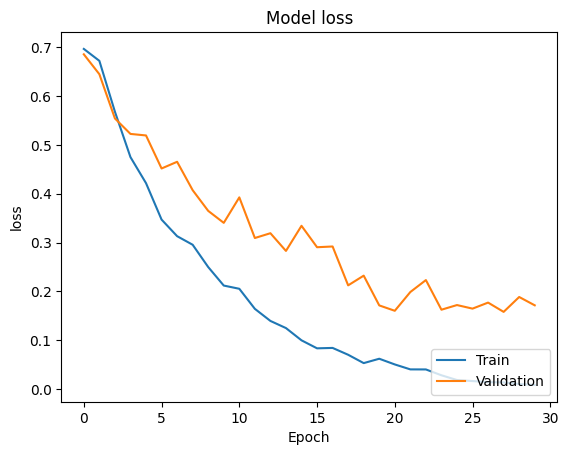

In [45]:
plot_history_metric(best_history, 'loss')

#### Accuracy

The 'accuracy' metric measures the how many images were classified correctly out of the total number of images.
<br> High accuracy value indicates that the model is making more accurate predictions.

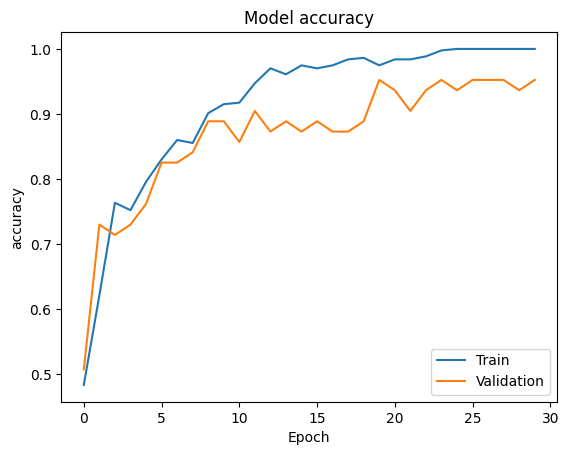

In [46]:
plot_history_metric(best_history, 'accuracy')

#### Precision

The 'precision' metric measures how many true positive predictions we have out of the total number of positive predictions made by the model.
<br> A higher precision value indicates that the model is making fewer false positive predictions.

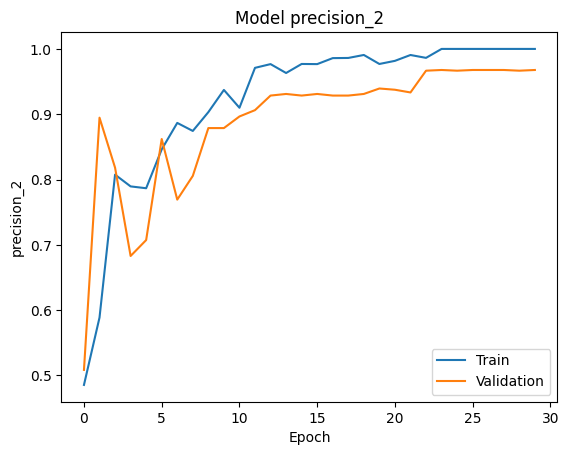

In [50]:
precision_metric_key = list(best_history.history.keys())[2]
plot_history_metric(best_history, precision_metric_key)

#### Recall

The 'recall' metric measures how many true positive predictions we have out of the total number of actual positive records in our data.
<br> A higher recall value indicates that the model is able to identify more positive instances correctly.

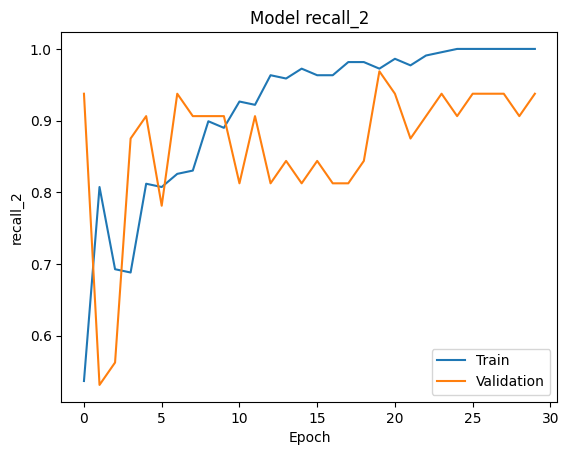

In [51]:
recall_metric_key = list(best_history.history.keys())[3]

plot_history_metric(best_history, recall_metric_key)

### Metrics Evaluation Conclusion

We can see that generally our best model generalizes the test data as well as the training data.

### Confusion Matrix

A confusion matrix is often used to describe the performance of a classification algorithm, so it fits the case of our task - CNN for image classification.

This kind of metric can be useful in understanding where the model is making errors.

In [56]:
best_test_acc = accuracy_score(y_test, y_pred)

print(f"Train accuracy = {best_train_acc}")
print(f"Test accuracy = {best_test_acc}\n")

Train accuracy = 1.0
Test accuracy = 0.96



Text(50.722222222222214, 0.5, 'True label')

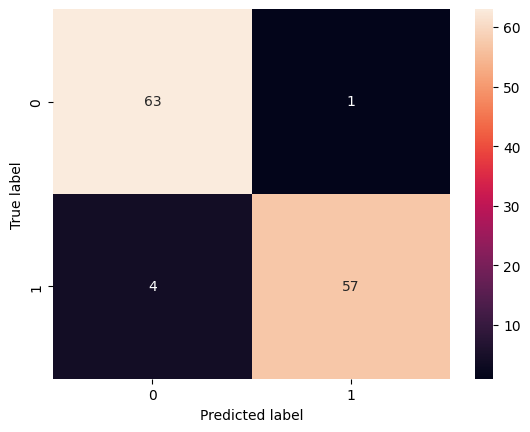

In [59]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')

#### Confusion Matrix Conclusion

We can see that our best model has mistaken in his prediction for only **4** inputs out of 125 total records.

### Precision-Recall Curve

Precision-Recall curve is a graphical representation of the trade-off between precision and recall for a given classifier or model, in our case - a CNN for image classification.

The precision-recall curve can be used to select the best threshold for the model to make predictions.

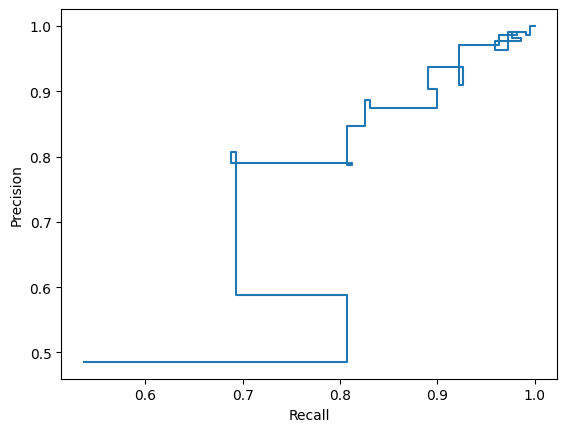

In [62]:
disp = PrecisionRecallDisplay(precision=best_history.history[precision_metric_key],
                              recall=best_history.history[recall_metric_key])

disp.plot()

#### Precision-Recall Curve conclusion

In general, a classifier with perfect precision and recall will have a precision-recall curve that reaches the top-left corner of the plot, because the graph represents the trade off between precision and recall.

In our case, our best model made very few false positive mistakes (as can be seen in the `Confusion Matrix`) and that is the reason for our curve reaching the top right corner - which indicates the model's very good performance.

### ROC Curve

ROC (Receiver Operating Characteristic) curve is used to represent the
performance of a binary classifier graphically.

In the graph we can see the trade off between the recall and the false positive rate.

Another metric we get from ROC curve is AUC - Area Under the Curve. This metric gives a measurement on the performance of the model.

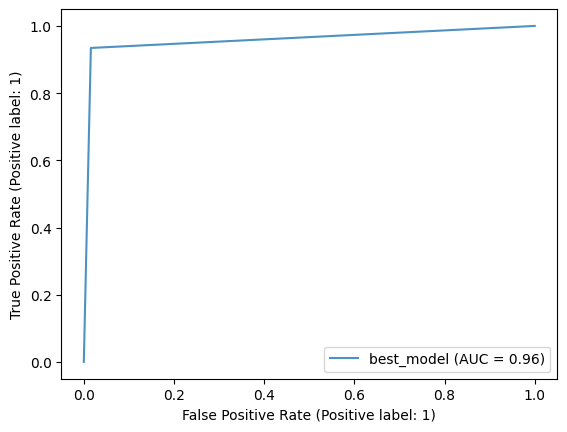

In [63]:
ax = plt.gca()

RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax, alpha=0.8, name="best_model")

plt.show()

#### ROC Curve Conclusions

Our best model reaches the top left corner, which means it has a very high true positive rate and a very low false positive rate.

We can also see that the AUC value is **0.96**, which is very high, coresponding to our model's high performance.

## Discussion

### Does the model overfit?

No, the model does not overfit.

- First, high accuracy and/or low loss on training data are not necessarily indications for overfitting.
- As we can see in the ```Model Evaluation```
 section in the notebook, when we compare the train and validation metrics evaluation results, we see that our model performs pretty well on the validation set as well. From that we can infer that our model has geneleralized new data (validation set) well after learning the training data set well also. This points that our model is not overfiting because it generalizes new data pretty well.
- Another indication for not our model not overfitting - there is no big difference in accuracy results for the train and test set.

### What is the effect of batch size? Do we observe this effect in the current task?

Generally in CNN, batch size controls the number of samples that are propagated through the network before a weight update is performed.

Batch size can have two effects on CNN:

1. Larger batch sizes generally lead to more efficient use of computational resources. Very large batch sizes may also cause the model to use up too much memory and slow down the training process.

2. Smaller batch sizes can help stabilize the training process by introducing more noise to the weight updates, which can prevent the model from getting stuck in some local optima or overfitting the training data.

**In this task**, we ran grid search to also find the optimal batch size hyperparameter.

We first ran the base model with batch size of 32 (Keras' default for CNN image classification model).

Then we ran grid search with two options: 32, 64.

After the grid search we get that batch size of 32 is optimal, so we can see the 2nd effect.

### What was the optimal optimizer? Why?

According to the grid search results, 'ADAM' was the optimal optimizer.
It is known to be a good optimizer for different tasks, especially for image classification.

Two main reasons for 'ADAM' to be an optimal optimizer are:

1. 'ADAM' adapts the learning rate for each parameter, which can help the optimizer converge faster and more effectively than an optimizer with a fixed learning rate.

2. 'ADAM' uses the idea of momentum, which helps the optimizer to avoid getting stuck in some local optima.

More general advantages of 'ADAM' optimizer:

- Computationally efficient.
- Little memory requirements.
- Invariant to diagonal rescale of the gradients.
- Well suited for problems that are large in terms of data and/or parameters.
- Appropriate for non-stationary objectives.
- Appropriate for problems with very noisy or sprase gradients.
- Hyper-parameters have intuitive iterpretation and typically require little tuning.